In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from functools import reduce

from scipy.interpolate import griddata
import matplotlib.colors as colors
import time

import numpy as np
import DataPreprocessing
import SplitDataSet

In [2]:
def transform(me):
    return np.multiply(np.sign(me), np.power(abs(me), 0.5))
def inverse(temp):
    return np.multiply(np.sign(temp), np.power(abs(temp), 1/0.5))
def inverse_tf(temp):
    return tf.multiply(tf.sign(temp), tf.pow(tf.abs(temp), 1/0.5)) 
def frac_error(true, experimental):
    return np.abs(np.divide(inverse(true) - inverse(experimental), inverse(true)))

In [8]:
def perc_error(true, experimental):
    return 100*tf.abs(tf.divide(inverse_tf(true) - inverse_tf(experimental), inverse_tf(true)))

def build_model(components=50, activation='relu'):
    #activation = keras.
    model = keras.Sequential([
        keras.layers.Dense(50, activation='elu', input_shape=[12]), #could try swish??  
        keras.layers.Dense(100, activation='elu'),
        keras.layers.Dense(150, activation='elu'),
        keras.layers.Dense(100, activation='elu'),
        keras.layers.Dense(50, activation='elu'),
        
        keras.layers.Dense(1, activation='linear') 
    ])

    adam = tf.keras.optimizers.Adam(0.0005)
    model.compile(loss='mse', 
                optimizer=adam, metrics=['mape', perc_error])
    return model

In [9]:
def calc_RMSE(mom_train, mom_test, rescaled_train, rescaled_test, reuse_model=False):
    if reuse_model:
        model = build_model()
        model.load_weights("LO/MODEL/uuuxux.hdf5")
    else:
        model = build_model()
    
    temp_train = rescaled_train
    temp_test = rescaled_test
    
    scaler = StandardScaler()

    poly_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train[:,1:]])
    poly_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test[:,1:]])
    poly_train = scaler.fit_transform(poly_train) #Rescale on training set
    poly_test = scaler.transform(poly_test)

    
        # Saves the best model's weights
    checkpoint_path = "LO/MODEL/uuuxux.hdf5"
    callback_a = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=True)
    callback_b = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
    tic = time.perf_counter()
    history = model.fit(poly_train, temp_train, batch_size=256, epochs=5000, 
                        shuffle=True, verbose=1, callbacks=[callback_b, callback_a],
                       validation_data=(poly_test, temp_test))
    toc = time.perf_counter()
    print(f"Training ran in {toc - tic:0.4f} seconds")

    try:
        # load the saved model
        saved_model = build_model()
        saved_model.load_weights(checkpoint_path)
        
        
        train_predict = saved_model.predict(poly_train)
        train_predict.shape = (len(train_predict))  
        train_perc = 100*np.mean(np.abs((temp_train - train_predict) / temp_train))                              
        
        
        train_predict = saved_model.predict(poly_train)
        train_predict.shape = (len(train_predict))     
        train_error = 100*np.mean(frac_error(temp_train, train_predict))                                 
        
        tic = time.perf_counter()
        test_predict = saved_model.predict(poly_test)
        toc = time.perf_counter()
        print(f"Prediction ran in {toc - tic:0.4f} seconds")
        
        test_predict.shape = (len(test_predict))
        test_error = 100*np.mean(frac_error(temp_test, test_predict))

        print('Train: %.3f, Test: %.3f' % (train_error, test_error))
        
        np.save('LO/uuuxux/pred_nn_div(1).npy', test_predict)
        
        return(np.abs((temp_test - test_predict) / temp_test), temp_test**2 - test_predict**2, history)
    except ValueError:
        print('Value Error Encountered')       
    return(0, 0, 0, 0)

In [5]:
##Obtain & process data NPY
me_train, mom_train = SplitDataSet.smallestS('LO/uuuxux/me_1000000.npy', 'LO/uuuxux/mom_1000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('LO/uuuxux/me_500000.npy', 'LO/uuuxux/mom_500000.npy', 1)


me_tr_0, mom_tr_0 = SplitDataSet.smallestS('LO/uuuxux/me_1000000.npy', 'LO/uuuxux/mom_1000000.npy', 2)
mom_tr_0[:,[2,3]] = mom_tr_0[:,[3,2]]

me_te_0, mom_te_0 = SplitDataSet.smallestS('LO/uuuxux/me_500000.npy', 'LO/uuuxux/mom_500000.npy', 2)
mom_te_0[:,[2,3]] = mom_te_0[:,[3,2]]


me_tr_1, mom_tr_1 = SplitDataSet.smallestS('LO/uuuxux/me_1000000.npy', 'LO/uuuxux/mom_1000000.npy', 3)
mom_tr_1[:,[0,1]] = mom_tr_1[:,[1,0]]

me_te_1, mom_te_1 = SplitDataSet.smallestS('LO/uuuxux/me_500000.npy', 'LO/uuuxux/mom_500000.npy', 3)
mom_te_1[:,[0,1]] = mom_te_1[:,[1,0]]


me_tr_2, mom_tr_2 = SplitDataSet.smallestS('LO/uuuxux/me_1000000.npy', 'LO/uuuxux/mom_1000000.npy', 4)
mom_tr_2[:,[0,1,2,3]] = mom_tr_2[:,[1,0,3,2]]

me_te_2, mom_te_2 = SplitDataSet.smallestS('LO/uuuxux/me_500000.npy', 'LO/uuuxux/mom_500000.npy', 4)
mom_te_2[:,[0,1,2,3]] = mom_te_2[:,[1,0,3,2]]


mom_train = np.concatenate([mom_train, mom_tr_0, mom_tr_1, mom_tr_2],axis=0)
me_train = np.concatenate([me_train, me_tr_0, me_tr_1, me_tr_2],axis=0)

mom_test = np.concatenate([mom_test, mom_te_0, mom_te_1, mom_te_2],axis=0)
me_test = np.concatenate([me_test, me_te_0, me_te_1, me_te_2],axis=0)

Split ran in 3.0766 seconds
Split ran in 1.3663 seconds
Split ran in 3.0641 seconds
Split ran in 1.3602 seconds
Split ran in 3.0143 seconds
Split ran in 1.3760 seconds
Split ran in 2.9976 seconds
Split ran in 1.3893 seconds


In [2]:
me_train, mom_train = SplitDataSet.smallestS('LO/uuuxux/me_1000000.npy', 'LO/uuuxux/mom_1000000.npy', 0)
me_test, mom_test = SplitDataSet.smallestS('LO/uuuxux/me_500000.npy', 'LO/uuuxux/mom_500000.npy', 0)

me_tr, mom_tr = SplitDataSet.smallestS('LO/uuuxux/me_1000000.npy', 'LO/uuuxux/mom_1000000.npy', 5)
mom_tr[:,[0,1,2,3]] = mom_tr[:,[2,3,0,1]]

me_te, mom_te = SplitDataSet.smallestS('LO/uuuxux/me_500000.npy', 'LO/uuuxux/mom_500000.npy', 5)
mom_te[:,[0,1,2,3]] = mom_te[:,[2,3,0,1]]


mom_train = np.concatenate([mom_train, mom_tr],axis=0)
me_train = np.concatenate([me_train, me_tr],axis=0)

mom_test = np.concatenate([mom_test, mom_te],axis=0)
me_test = np.concatenate([me_test, me_te],axis=0)

Split ran in 3.2556 seconds
Split ran in 1.4119 seconds
Split ran in 3.1293 seconds
Split ran in 1.4647 seconds


In [10]:
combs = ['1,3','2,3','1,4','2,4','1,2,3','1,2,4','1,3,4','2,3,4']

tic = time.perf_counter()
div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(combs, mom_train))
temp_train = np.multiply(div_train, me_train)
toc = time.perf_counter()
print(f"Test multiplication ran in {toc - tic:0.4f} seconds")

tic = time.perf_counter()
div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(combs, mom_test))
temp_test = np.multiply(div_test, me_test)
toc = time.perf_counter()
print(f"Test multiplication ran in {toc - tic:0.4f} seconds")

Test multiplication ran in 0.9879 seconds
Test multiplication ran in 0.3487 seconds


In [11]:
print('Std : {}'.format(np.std(temp_train)))
print('Mean : {}'.format(np.mean(temp_train)))
print(len(temp_test))

std = np.std(temp_train)
temp_train = transform(temp_train/std)
temp_test = transform(temp_test/std)

perc, mse, history = calc_RMSE(mom_train, mom_test, temp_train, temp_test, reuse_model=True)

Std : 1.3583218957743333e+31
Mean : 1.4797762592476182e+31
333079
Train on 666666 samples, validate on 333079 samples
Epoch 1/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us/step - loss: 3.4451e-04 - mean_absolute_percentage_error: 2.1794 - perc_error: 4.4892 - val_loss: 5.4073e-04 - val_mean_absolute_percentage_error: 2.3814 - val_perc_error: 5.1051

Epoch 2/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 3.2938e-04 - mean_absolute_percentage_error: 2.1423 - perc_error: 4.4192 - val_loss: 4.7627e-04 - val_mean_absolute_percentage_error: 2.3200 - val_perc_error: 4.7929

Epoch 3/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 3.2235e-04 - mean_absolute_percentage_error: 2.1212 - perc_error: 4.3601 - val_loss: 4.9631e-04 - val_mean_absolute_percentage_error: 2.3272 - val_perc_error:

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.9599e-04 - mean_absolute_percentage_error: 2.0301 - perc_error: 4.1890 - val_loss: 4.7891e-04 - val_mean_absolute_percentage_error: 2.2785 - val_perc_error: 4.8383

Epoch 29/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.8839e-04 - mean_absolute_percentage_error: 2.0136 - perc_error: 4.1498 - val_loss: 4.3311e-04 - val_mean_absolute_percentage_error: 2.1424 - val_perc_error: 4.5336

Epoch 30/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.9788e-04 - mean_absolute_percentage_error: 2.0284 - perc_error: 4.1764 - val_loss: 5.2207e-04 - val_mean_absolute_percentage_error: 2.3690 - val_perc_error: 5.0707

Epoch 31/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/st

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.9303e-04 - mean_absolute_percentage_error: 1.9945 - perc_error: 4.1280 - val_loss: 4.2501e-04 - val_mean_absolute_percentage_error: 2.2160 - val_perc_error: 4.6617

Epoch 56/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 2.7704e-04 - mean_absolute_percentage_error: 1.9644 - perc_error: 4.0460 - val_loss: 4.3251e-04 - val_mean_absolute_percentage_error: 2.1975 - val_perc_error: 4.6535

Epoch 57/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.7312e-04 - mean_absolute_percentage_error: 1.9558 - perc_error: 4.0260 - val_loss: 4.2904e-04 - val_mean_absolute_percentage_error: 2.1776 - val_perc_error: 4.7391

Epoch 58/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/st

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.7565e-04 - mean_absolute_percentage_error: 1.9429 - perc_error: 3.9983 - val_loss: 4.0166e-04 - val_mean_absolute_percentage_error: 2.0538 - val_perc_error: 4.4196

Epoch 83/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us/step - loss: 2.7307e-04 - mean_absolute_percentage_error: 1.9417 - perc_error: 3.9982 - val_loss: 4.1201e-04 - val_mean_absolute_percentage_error: 2.2088 - val_perc_error: 4.7912

Epoch 84/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.8243e-04 - mean_absolute_percentage_error: 1.9595 - perc_error: 4.0359 - val_loss: 3.9976e-04 - val_mean_absolute_percentage_error: 2.0522 - val_perc_error: 4.2576

Epoch 85/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/st

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.6481e-04 - mean_absolute_percentage_error: 1.9085 - perc_error: 3.9238 - val_loss: 3.9121e-04 - val_mean_absolute_percentage_error: 2.0673 - val_perc_error: 4.3563

Epoch 110/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.7001e-04 - mean_absolute_percentage_error: 1.9208 - perc_error: 3.9486 - val_loss: 4.1539e-04 - val_mean_absolute_percentage_error: 2.2145 - val_perc_error: 4.5126

Epoch 111/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.6478e-04 - mean_absolute_percentage_error: 1.9128 - perc_error: 3.9530 - val_loss: 4.0330e-04 - val_mean_absolute_percentage_error: 2.1051 - val_perc_error: 4.5796

Epoch 112/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us

666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 2.7232e-04 - mean_absolute_percentage_error: 1.9242 - perc_error: 3.9600 - val_loss: 3.8846e-04 - val_mean_absolute_percentage_error: 2.0847 - val_perc_error: 4.2655

Epoch 137/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.6228e-04 - mean_absolute_percentage_error: 1.8951 - perc_error: 3.9114 - val_loss: 4.1256e-04 - val_mean_absolute_percentage_error: 2.0887 - val_perc_error: 4.4449

Epoch 138/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.6273e-04 - mean_absolute_percentage_error: 1.9010 - perc_error: 3.9137 - val_loss: 3.8723e-04 - val_mean_absolute_percentage_error: 2.0050 - val_perc_error: 4.2707

Epoch 139/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.7376e-04 - mean_absolute_percentage_error: 1.9075 - perc_error: 3.9394 - val_loss: 3.6835e-04 - val_mean_absolute_percentage_error: 1.9696 - val_perc_error: 4.2084

Epoch 164/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.5917e-04 - mean_absolute_percentage_error: 1.8808 - perc_error: 3.8727 - val_loss: 5.0367e-04 - val_mean_absolute_percentage_error: 2.4790 - val_perc_error: 5.3717

Epoch 165/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.7153e-04 - mean_absolute_percentage_error: 1.8928 - perc_error: 3.9040 - val_loss: 3.7258e-04 - val_mean_absolute_percentage_error: 1.9976 - val_perc_error: 4.1618

Epoch 166/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4994e-04 - mean_absolute_percentage_error: 1.8590 - perc_error: 3.8279 - val_loss: 3.6311e-04 - val_mean_absolute_percentage_error: 1.9366 - val_perc_error: 4.1216

Epoch 191/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.5826e-04 - mean_absolute_percentage_error: 1.8784 - perc_error: 3.8689 - val_loss: 3.9794e-04 - val_mean_absolute_percentage_error: 2.0867 - val_perc_error: 4.5208

Epoch 192/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.6730e-04 - mean_absolute_percentage_error: 1.8952 - perc_error: 3.9029 - val_loss: 3.7779e-04 - val_mean_absolute_percentage_error: 1.9719 - val_perc_error: 4.2366

Epoch 193/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.6115e-04 - mean_absolute_percentage_error: 1.8688 - perc_error: 3.8512 - val_loss: 3.8676e-04 - val_mean_absolute_percentage_error: 1.9852 - val_perc_error: 4.1330

Epoch 218/5000
666666/666666 [==============================]666666/666666 [==============================] - 15s 22us/step - loss: 2.5999e-04 - mean_absolute_percentage_error: 1.8703 - perc_error: 3.8449 - val_loss: 3.4552e-04 - val_mean_absolute_percentage_error: 1.9177 - val_perc_error: 4.0953

Epoch 219/5000
666666/666666 [==============================]666666/666666 [==============================] - 15s 22us/step - loss: 2.5676e-04 - mean_absolute_percentage_error: 1.8601 - perc_error: 3.8288 - val_loss: 3.8019e-04 - val_mean_absolute_percentage_error: 2.0179 - val_perc_error: 4.2509

Epoch 220/5000
666666/666666 [==============================]666666/666666 [==============================] - 15s 22us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.5173e-04 - mean_absolute_percentage_error: 1.8490 - perc_error: 3.8052 - val_loss: 3.8529e-04 - val_mean_absolute_percentage_error: 1.9840 - val_perc_error: 4.1558

Epoch 245/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us/step - loss: 2.6742e-04 - mean_absolute_percentage_error: 1.8780 - perc_error: 3.8662 - val_loss: 5.5947e-04 - val_mean_absolute_percentage_error: 2.4496 - val_perc_error: 5.1763

Epoch 246/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us/step - loss: 2.6308e-04 - mean_absolute_percentage_error: 1.8700 - perc_error: 3.8449 - val_loss: 3.7834e-04 - val_mean_absolute_percentage_error: 1.9520 - val_perc_error: 4.1063

Epoch 247/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.5564e-04 - mean_absolute_percentage_error: 1.8521 - perc_error: 3.8155 - val_loss: 3.5840e-04 - val_mean_absolute_percentage_error: 1.9849 - val_perc_error: 4.3025

Epoch 272/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4754e-04 - mean_absolute_percentage_error: 1.8296 - perc_error: 3.7758 - val_loss: 3.9952e-04 - val_mean_absolute_percentage_error: 2.1514 - val_perc_error: 4.7026

Epoch 273/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.5400e-04 - mean_absolute_percentage_error: 1.8411 - perc_error: 3.7818 - val_loss: 3.6296e-04 - val_mean_absolute_percentage_error: 1.9029 - val_perc_error: 4.0178

Epoch 274/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4366e-04 - mean_absolute_percentage_error: 1.8274 - perc_error: 3.7636 - val_loss: 3.4333e-04 - val_mean_absolute_percentage_error: 1.8615 - val_perc_error: 3.9142

Epoch 299/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us/step - loss: 2.6366e-04 - mean_absolute_percentage_error: 1.8679 - perc_error: 3.8422 - val_loss: 4.0211e-04 - val_mean_absolute_percentage_error: 2.1535 - val_perc_error: 4.6083

Epoch 300/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4099e-04 - mean_absolute_percentage_error: 1.8142 - perc_error: 3.7337 - val_loss: 4.2559e-04 - val_mean_absolute_percentage_error: 2.2305 - val_perc_error: 4.8705

Epoch 301/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4606e-04 - mean_absolute_percentage_error: 1.8121 - perc_error: 3.7316 - val_loss: 3.5216e-04 - val_mean_absolute_percentage_error: 1.8826 - val_perc_error: 3.8882

Epoch 326/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.6023e-04 - mean_absolute_percentage_error: 1.8486 - perc_error: 3.8016 - val_loss: 3.5206e-04 - val_mean_absolute_percentage_error: 1.9373 - val_perc_error: 4.0007

Epoch 327/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3280e-04 - mean_absolute_percentage_error: 1.7882 - perc_error: 3.6817 - val_loss: 3.5986e-04 - val_mean_absolute_percentage_error: 1.9466 - val_perc_error: 4.1910

Epoch 328/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4761e-04 - mean_absolute_percentage_error: 1.8237 - perc_error: 3.7551 - val_loss: 6.9847e-04 - val_mean_absolute_percentage_error: 2.8247 - val_perc_error: 6.1172

Epoch 353/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 2.4908e-04 - mean_absolute_percentage_error: 1.8282 - perc_error: 3.7593 - val_loss: 3.3340e-04 - val_mean_absolute_percentage_error: 1.8886 - val_perc_error: 4.0335

Epoch 354/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4159e-04 - mean_absolute_percentage_error: 1.8077 - perc_error: 3.7201 - val_loss: 4.8293e-04 - val_mean_absolute_percentage_error: 2.1420 - val_perc_error: 4.3365

Epoch 355/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4132e-04 - mean_absolute_percentage_error: 1.8062 - perc_error: 3.7138 - val_loss: 3.5441e-04 - val_mean_absolute_percentage_error: 1.9112 - val_perc_error: 3.9620

Epoch 380/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4146e-04 - mean_absolute_percentage_error: 1.8098 - perc_error: 3.7225 - val_loss: 6.2297e-04 - val_mean_absolute_percentage_error: 2.4454 - val_perc_error: 5.1058

Epoch 381/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 2.4682e-04 - mean_absolute_percentage_error: 1.8141 - perc_error: 3.7262 - val_loss: 3.2786e-04 - val_mean_absolute_percentage_error: 1.8382 - val_perc_error: 3.8077

Epoch 382/5000
666666/666666 [==============================]666666/666666 [==============================] - 13s 19us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3535e-04 - mean_absolute_percentage_error: 1.7857 - perc_error: 3.6761 - val_loss: 4.1346e-04 - val_mean_absolute_percentage_error: 2.0665 - val_perc_error: 4.3006

Epoch 407/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4425e-04 - mean_absolute_percentage_error: 1.8075 - perc_error: 3.7190 - val_loss: 3.5561e-04 - val_mean_absolute_percentage_error: 2.0565 - val_perc_error: 4.1336

Epoch 408/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.5222e-04 - mean_absolute_percentage_error: 1.8269 - perc_error: 3.7617 - val_loss: 3.6552e-04 - val_mean_absolute_percentage_error: 2.0226 - val_perc_error: 4.3773

Epoch 409/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 13s 19us/step - loss: 2.4551e-04 - mean_absolute_percentage_error: 1.8001 - perc_error: 3.6958 - val_loss: 3.6388e-04 - val_mean_absolute_percentage_error: 1.9260 - val_perc_error: 4.0051

Epoch 434/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3669e-04 - mean_absolute_percentage_error: 1.7873 - perc_error: 3.6711 - val_loss: 3.8607e-04 - val_mean_absolute_percentage_error: 1.9974 - val_perc_error: 4.2477

Epoch 435/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4228e-04 - mean_absolute_percentage_error: 1.8038 - perc_error: 3.7066 - val_loss: 4.3901e-04 - val_mean_absolute_percentage_error: 2.1940 - val_perc_error: 4.7484

Epoch 436/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3702e-04 - mean_absolute_percentage_error: 1.7800 - perc_error: 3.6565 - val_loss: 3.9912e-04 - val_mean_absolute_percentage_error: 2.0468 - val_perc_error: 4.1930

Epoch 461/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3814e-04 - mean_absolute_percentage_error: 1.7886 - perc_error: 3.6724 - val_loss: 3.4004e-04 - val_mean_absolute_percentage_error: 1.8367 - val_perc_error: 3.8154

Epoch 462/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4087e-04 - mean_absolute_percentage_error: 1.7902 - perc_error: 3.6807 - val_loss: 3.5895e-04 - val_mean_absolute_percentage_error: 1.9175 - val_perc_error: 4.0797

Epoch 463/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3522e-04 - mean_absolute_percentage_error: 1.7809 - perc_error: 3.6623 - val_loss: 5.4341e-04 - val_mean_absolute_percentage_error: 2.2375 - val_perc_error: 4.5634

Epoch 488/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3715e-04 - mean_absolute_percentage_error: 1.7869 - perc_error: 3.6823 - val_loss: 3.6687e-04 - val_mean_absolute_percentage_error: 1.9800 - val_perc_error: 4.2329

Epoch 489/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.4559e-04 - mean_absolute_percentage_error: 1.8033 - perc_error: 3.7271 - val_loss: 3.9078e-04 - val_mean_absolute_percentage_error: 2.0067 - val_perc_error: 4.2098

Epoch 490/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.7098e-04 - mean_absolute_percentage_error: 1.8299 - perc_error: 3.7582 - val_loss: 3.5304e-04 - val_mean_absolute_percentage_error: 1.9215 - val_perc_error: 3.9266

Epoch 515/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 2.1080e-04 - mean_absolute_percentage_error: 1.7162 - perc_error: 3.5358 - val_loss: 3.9797e-04 - val_mean_absolute_percentage_error: 1.9559 - val_perc_error: 4.1934

Epoch 516/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.5059e-04 - mean_absolute_percentage_error: 1.8174 - perc_error: 3.7391 - val_loss: 3.8610e-04 - val_mean_absolute_percentage_error: 1.9615 - val_perc_error: 4.0642

Epoch 517/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 2.2821e-04 - mean_absolute_percentage_error: 1.7622 - perc_error: 3.6162 - val_loss: 3.7759e-04 - val_mean_absolute_percentage_error: 2.1934 - val_perc_error: 4.3344

Epoch 542/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.2638e-04 - mean_absolute_percentage_error: 1.7579 - perc_error: 3.6126 - val_loss: 3.4364e-04 - val_mean_absolute_percentage_error: 1.8803 - val_perc_error: 3.8830

Epoch 543/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 2.3053e-04 - mean_absolute_percentage_error: 1.7660 - perc_error: 3.6248 - val_loss: 3.2746e-04 - val_mean_absolute_percentage_error: 1.8203 - val_perc_error: 3.8388

Epoch 544/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3477e-04 - mean_absolute_percentage_error: 1.7754 - perc_error: 3.6565 - val_loss: 3.5756e-04 - val_mean_absolute_percentage_error: 1.8968 - val_perc_error: 3.9743

Epoch 569/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3562e-04 - mean_absolute_percentage_error: 1.7717 - perc_error: 3.6405 - val_loss: 3.4273e-04 - val_mean_absolute_percentage_error: 1.8564 - val_perc_error: 3.9006

Epoch 570/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.2846e-04 - mean_absolute_percentage_error: 1.7646 - perc_error: 3.6358 - val_loss: 3.1117e-04 - val_mean_absolute_percentage_error: 1.7489 - val_perc_error: 3.6979

Epoch 571/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.7988e-04 - mean_absolute_percentage_error: 1.8423 - perc_error: 3.8035 - val_loss: 3.2050e-04 - val_mean_absolute_percentage_error: 1.7536 - val_perc_error: 3.6981

Epoch 596/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.1309e-04 - mean_absolute_percentage_error: 1.7184 - perc_error: 3.5341 - val_loss: 4.2551e-04 - val_mean_absolute_percentage_error: 2.0355 - val_perc_error: 4.3223

Epoch 597/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us/step - loss: 2.2689e-04 - mean_absolute_percentage_error: 1.7539 - perc_error: 3.6062 - val_loss: 3.4663e-04 - val_mean_absolute_percentage_error: 1.8770 - val_perc_error: 3.9736

Epoch 598/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us

666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3837e-04 - mean_absolute_percentage_error: 1.7705 - perc_error: 3.6386 - val_loss: 3.2828e-04 - val_mean_absolute_percentage_error: 1.8881 - val_perc_error: 4.0399

Epoch 623/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.3019e-04 - mean_absolute_percentage_error: 1.7434 - perc_error: 3.5854 - val_loss: 3.1087e-04 - val_mean_absolute_percentage_error: 1.7988 - val_perc_error: 3.8492

Epoch 624/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 18us/step - loss: 2.2633e-04 - mean_absolute_percentage_error: 1.7485 - perc_error: 3.6039 - val_loss: 3.6415e-04 - val_mean_absolute_percentage_error: 1.9571 - val_perc_error: 4.1943

Epoch 625/5000
666666/666666 [==============================]666666/666666 [==============================] - 12s 19us

In [6]:
from matplotlib import rcParams

rcParams['font.family'] = 'Serif'
rcParams['font.size'] = 11

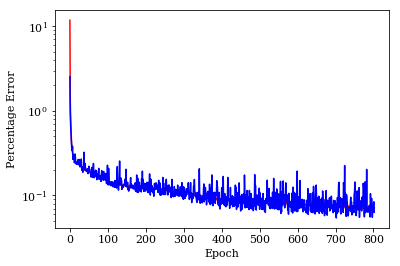

In [7]:
##LEARNING CURVE
points = len(history.history['loss'])
pyplot.plot(range(points), history.history['mean_absolute_percentage_error'], color='r', label='Training Set')
pyplot.plot(range(points), history.history['val_mean_absolute_percentage_error'],color='b', label='Val Set')
#pyplot.legend()
#pyplot.ylim(0,2)

pyplot.xlabel('Epoch')
pyplot.ylabel('Percentage Error')
pyplot.yscale('log')

In [ ]:
"LO/MODEL/uuxg.hdf5"

In [ ]:
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,3','2,3'], mom_test_r)
S = s12 + s13 + s23

In [ ]:
x1 = np.divide(s12, 1000000)
x2 = np.divide(s13, 1000000)
x3 = np.divide(s23, 1000000)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [ ]:
grid = griddata((x2, x3), perc, (X2i, X3i), method='linear')

In [ ]:
fig, ax = pyplot.subplots(figsize=(5, 3))
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
cbar.set_label('Percentage Error')

ax.set_xticks([0, 500])
ax.set_xticklabels([0, 1])
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('x2')
ax.set_xlabel('x3')
pyplot.savefig('errordalitz_nnet_3jetLO')

###DIVERGENT REGIONS


me_train, mom_train = SplitDataSet.smallestS('LO/uuxg/me_1000000.npy', 'LO/uuxg/mom_1000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('LO/uuxg/me_500000.npy', 'LO/uuxg/mom_500000.npy', 1)

me_swap, mom_swap = SplitDataSet.smallestS('LO/uuxg/me_1000000.npy', 'LO/uuxg/mom_1000000.npy', 2)
mom_swap[:,[0,1]] = mom_swap[:,[1,0]]

mom_train = np.concatenate([mom_train, mom_swap],axis=0)
me_train = np.concatenate([me_train, me_swap],axis=0)

me_swap, mom_swap = SplitDataSet.smallestS('LO/uuxg/me_500000.npy', 'LO/uuxg/mom_500000.npy', 2)
mom_swap[:,[0,1]] = mom_swap[:,[1,0]]

mom_test = np.concatenate([mom_test, mom_swap],axis=0)
me_test = np.concatenate([me_test, me_swap],axis=0)


98029
2019.3272833672818
0.733369616616983


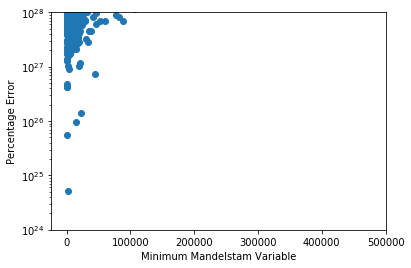

In [30]:
def error_smallest_S(perc_error, mom):
    print(np.argmin(perc_error))
    mandel_vars = DataPreprocessing.mandel_creation(['1,3','2,3'], mom)
    min_mandel_vars = [min(mandel_var) for mandel_var in mandel_vars.T]
    print(min_mandel_vars[np.argmin(perc_error)])
    print(min(min_mandel_vars))
    pyplot.scatter(min_mandel_vars,perc_error)
    pyplot.xlabel('Minimum Mandelstam Variable')
    pyplot.ylabel('Percentage Error')
    pyplot.ylim([1e24,1e28])
    pyplot.yscale('log')
    #pyplot.savefig('KBinsAtNLO')
error_smallest_S(temp_test, mom_test)